<a href="https://colab.research.google.com/github/IndranilPaul99/Read_alignment/blob/main/Bioinformatics_2022_CSE_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Creating Test Data**

## Function to generate a random Reference Genome

In [25]:
import random

def generate_Random_Reference_Genome( length_of_genome , gc_content ) :
    base_count = { "A" : 0 , "C" : 0 , "G" : 0 , "T" : 0 }
    base = ""
    g_or_c = gc_content / 2
    a_or_t = ( 100 + gc_content ) / 2
    genome = open("reference_genome","w")
    for i in range( length_of_genome ) :
        seed = random.uniform( 0 , 100 )
        if seed <= gc_content :
            if seed < g_or_c :
                base = "C"
            else :
                base = "G"
        else :
            if seed < a_or_t :
                base = "A"
            else :
                base = "T"
        genome.write( base )
        base_count[base] += 1
    genome.close()
    print(" Generation Complete!! \n" , base_count )

In [26]:
#@title Generate Reference Genome { vertical-output: true, display-mode: "form" }
length_of_genome = 10000 #@param {type:"integer"}
gc_content = 72 #@param {type:"slider", min:1, max:100, step:1}

generate_Random_Reference_Genome( length_of_genome , gc_content )


 Generation Complete!! 
 {'A': 1354, 'C': 3591, 'G': 3628, 'T': 1427}


## Function to create a Sample Genome from the Reference Genome with dissimilarities

In [27]:
import random

def create_Sample_Genome( variation_percentage ) :
    bases = {
        "A" : ["C" , "G" , "T" ],
        "C" : ["A" , "G" , "T" ],
        "G" : ["A" , "C" , "T" ],
        "T" : ["A" , "C" , "T" ]
    }

    reference_genome = open("reference_genome","r")
    sample_genome = open("sample_genome","w")

    count = 0
    while True:
        base = reference_genome.read(1)
        if not base :
            break
        r = random.uniform(0,100)
        if( r <= variation_percentage ) :
            count += 1
            sample_genome.write( random.choice(bases[base]) )
        else :
            sample_genome.write( base )
    reference_genome.close()
    sample_genome.close()
    print( " Number of dissimilarities = " , count )

In [28]:
#@title Generate Sample Genome { vertical-output: true, display-mode: "form" }
variance_of_sample_genome = 0.2 #@param {type:"slider", min:0, max:3, step:0.01}

create_Sample_Genome( variance_of_sample_genome )

 Number of dissimilarities =  28


## Function to create reads from Sample Genome
Offset of each read is saved for later verification.

In [29]:
import random

def generate_Reads( min_read_length , max_read_length , iterations , edit_percent , edit_ratio ) :
    sample_reads = open( "sample_reads" , "w" )
    read_indexes = open( "reads_indexes" , "w" )
    sample_genome = open( "sample_genome" , "r" )

    count = 0
    reads_with_edits = [ 0 for i in range( len(edit_ratio) ) ]
    for _ in range(iterations) :
        sample_genome.seek(0)
        while True :
            position_of_read = sample_genome.tell()
            read_length = random.randint( min_read_length , max_read_length )
            read = sample_genome.read( read_length )
            if not read :
                break
            if random.uniform( 0 , 100 ) <= edit_percent :
                seed = random.uniform( 0 , 100 )
                for i in range( len( edit_ratio ) ) :
                    if seed <= edit_ratio[i] :
                        edits = i+1
                        break
                if edits < len( read ) :
                    reads_with_edits[ edits-1 ] += 1
                    edit_offsets = random.sample( range( len(read) ) , edits )
                    for i in edit_offsets :
                        read = read[:i] +  read[i+1:]
            sample_reads.writelines( read + "\n" )
            read_indexes.write( str(position_of_read) + "\n" )
            count += 1
    
    sample_reads.close()
    read_indexes.close()
    sample_genome.close()
    print( " Number of reads produced = " , count , " \n Reads with edits = " , reads_with_edits )

In [30]:
#@title Extract Reads from Sample Genome { vertical-output: true, display-mode: "form" }
min_read_length =  20#@param {type:"integer"}
max_read_length = 30 #@param {type:"integer"}
iterations =  15#@param {type:"number"}
edit_percent = 2 #@param {type:"slider", min:0, max:4, step:0.01}
edits_per_read = 2 #@param {type:"slider", min:0, max:10, step:1}
#@markdown Enter Ratio for the number of edits
ratio = "5 2" #@param {type:"string"}

edit_ratio = [ int(i) for i in ratio.split() ]
sum = 0
for i in edit_ratio :
    sum += i
prev = 0
for i in range( len(edit_ratio) ) :
    edit_ratio[i] = (edit_ratio[i]/sum)*100 + prev
    prev = edit_ratio[i]
if min_read_length < max_read_length and min_read_length < length_of_genome and len(edit_ratio) is edits_per_read :
    generate_Reads( min_read_length , max_read_length , iterations , edit_percent , edit_ratio )
else :
    print( " Invalid values !!! " )


 Number of reads produced =  6026  
 Reads with edits =  [89, 28]


# **Burrows-Wheller Transform and FM Index**

## Making the Burrows-Wheeler Transform
Offset are also sorted in the order of the rotations i.e. the suffix array is created. This array records the position of each base of the BWT in the reference genome.

In [31]:
def burrows_wheeler() :
    genome = open( "reference_genome" , "r" ).read() + "$"
    offsets = [ i for i in range( len( genome ) ) ]
    offsets.sort( key = lambda i : genome[i:] + genome[:i] )

    with open( "f" , "w" ) as file1 , open( "l" , "w" ) as file2 , open( "offsets" , "w" ) as file3 :
        for i in offsets :
            rotation = genome[i:] + genome[:i]
            file1.write( rotation[0] )
            file2.write( rotation[-1] )
            file3.write( str(i) + "\n" )

    print( "BWT Produced !!!" )

burrows_wheeler()

BWT Produced !!!


## Making the Rank , Skip and Select Tables

In [32]:
def generate_Rank_Select_Skip() :
    bwt = open( "l" , "r" ).read()
    rank = { "$" : [] , "A" : [] , "C" : [] , "G" : [] , "T" : [] }
    temp_ranks = { "$" : -1 , "A" : -1 , "C" : -1 , "G" : -1 , "T" : -1 }
    skip = { "$" : 0 , "A" : 0 , "C" : 0 , "G" : 0 , "T" : 0 }
    select = { "$" : [] , "A" : [] , "C" : [] , "G" : [] , "T" : [] }
    
    for base in bwt :
        temp_ranks[base] += 1
        for ch in [ "$" , "A" , "C" , "G" , "T" ] :
            rank[ch].append( temp_ranks[ch] )
    prev = "$"
    for curr in [ "A" , "C" , "G" , "T" ] :
        skip[curr] = temp_ranks[prev] + skip[prev] + 1
        prev = curr
    for i in range( len( bwt ) ) :
        select[ bwt[i] ].append( i )
    with open( "rank" , "w" ) as file1 , open( "skip" , "w" ) as file2 , open( "select" , "w" ) as file3 :
        for ch in [ "$" , "A" , "C" , "G" , "T" ] :
            for num in rank[ch] :
                file1.write( str( num ) + " " )
            file1.write( "\n" )
            file2.write( str( skip[ch] ) + "\n" )
            for num in select[ch] :
                file3.write( str( num ) + " " )
            file3.write( "\n" )
    print( "rank , select , skip generated!!!" )

generate_Rank_Select_Skip()

rank , select , skip generated!!!


## Reversing The Burrows-Wheller Transform

In [33]:
def reverse_BWT() :
    rank = {}
    skip = {}
    with open( "rank" , "r" ) as f1 , open( "skip" , "r" ) as f2 :
        for base in [ "$" , "A" , "C" , "G" , "T" ] :
            rank.update( { base : [ int(i) for i in f1.readline().strip( " \n" ).split( " " ) ] } )
            skip.update( { base : int( f2.readline() ) } )
    bwt = open( "l" , "r" ).read()
    
    reversed_bwt = ""
    offset = 0
    while True :
        base = bwt[ offset ]
        if base is "$" :
            break
        reversed_bwt = base + reversed_bwt
        offset = skip[ base ] + rank[ base ][ offset ]
    
    reference_genome = open( "reference_genome" , "r" ).read()
    if reversed_bwt == reference_genome :
        print( "BWT reversal successful !!!" )
    else :
        print( "BWT reversal unsuccessful." )

reverse_BWT()

BWT reversal successful !!!


## BWT Class

In [34]:
class Burrows_Wheelers :

    offsets = None

    def __init__( self , file_name = "reference_genome" ) :
        self.genome = open( file_name , "r" ).read() + "$"
        self.length = len( self.genome )
        self.f , self.l = self.create_BWT()
        self.rank , self.skip , self.select = self.generate_Rank_Select_Skip()

    def __iter__( self ) :
        self.iterate_base = 0
        return self

    def __next__( self ) :
        if self.iterate_base < self.length :
            current_base = self.iterate_base
            self.iterate_base += 1
            return self.l[ current_base ]
        else :
            raise StopIteration
    
    def __getitem__(self, key) :
        return self.l[key]

    def create_BWT( self ) :
        l = ""
        r = ""
        self.offsets = [ i for i in range( self.length ) ]
        self.offsets.sort( key = lambda i : self.genome[i:] + self.genome[:i] )
        for i in self.offsets :
            rotation = self.genome[i:] + self.genome[:i]
            l += rotation[0]
            r += rotation[-1:]
        return l , r

    def generate_Rank_Select_Skip( self ) :
        rank = { "$" : [] , "A" : [] , "C" : [] , "G" : [] , "T" : [] }
        skip = { "$" : 0 , "A" : 0 , "C" : 0 , "G" : 0 , "T" : 0 }
        select = { "$" : [] , "A" : [] , "C" : [] , "G" : [] , "T" : [] }
        
        for ch in [ "$" , "A" , "C" , "G" , "T" ] :
            temp = 0
            for base in self.l :
                rank[ch].append( temp )
                if( base is ch ) :
                    temp += 1
            rank[ch].append( temp )
        prev = "$"
        for curr in [ "A" , "C" , "G" , "T" ] :
            skip[curr] = rank[prev][self.length] + skip[prev]
            prev = curr
        for i in range( self.length ) :
            select[ self.l[i] ].append( i )
        return rank , skip , select

    def suffix( self , index = 0 ) :
        if ( index < 0 or index >= self.length ) :
            return None
        index +=1
        sfx = ""
        offset = 0
        while index < self.length :
            base = self.l[ offset ]
            sfx = base + sfx
            offset = self.skip[ base ] + self.rank[ base ][ offset ]
            index += 1
        return sfx

    def match( self , read ) :
        top = 0
        bot = self.length
        i = len( read ) - 1
        while i >= 0 and top < bot :
            base = read[ i ]
            top = self.skip[ base ] + self.rank[ base ][ top ]
            bot = self.skip[ base ] + self.rank[ base ][ bot ]
            i -= 1
        return [ self.offsets[x] for x in range( top , bot) ]

# **Read Alignment**

## Exact Read Alignment using only LF-Mapping

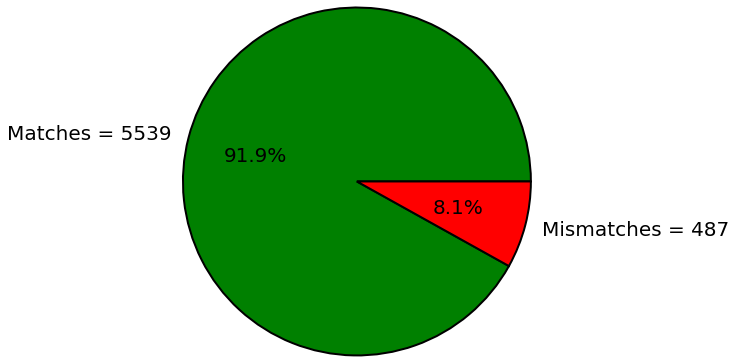

In [35]:
import matplotlib.pyplot as plt

def exact_Read_alignment() :
    matches = 0
    mismatches = 0
    bwt = Burrows_Wheelers()
    with open( "sample_reads" , "r" ) as f1 , open( "reads_indexes" , "r" ) as f2 :
        for read in f1 :
            offset = int(f2.readline())
            result = bwt.match( read.strip("\n") )
            if offset in result :
                matches += 1
            else :
                mismatches += 1
    return ( matches , mismatches )

values = exact_Read_alignment()
mywedge = { "edgecolor" : "0" , "linewidth" : 2 , "linestyle" : "solid" , "antialiased" : True }
mylabels = [ "Matches = " + str(values[0]) , "Mismatches = " + str(values[1]) ]
mytext = {'fontsize': 20}
plt.pie( values , labels = mylabels , colors = [ "green" , "red" ] , autopct="%1.1f%%" , wedgeprops = mywedge , radius = 2 , textprops = mytext )
plt.show()

## Approximate Matching Using Pigeonhole Principle

In [36]:
def linear_verification( read , bwt , offset , allowable_mismatches ) :
    mismatches = 0
    for i in range(len(read)) :
        if not read[i] == bwt.genome[offset+i] :
            mismatches += 1
            if mismatches > allowable_mismatches :
                break
    return mismatches

def pigeonhole( read , bwt , allowable_mismatches ) :
    slices = allowable_mismatches
    segment_length = round(len(read) / (slices+1))
    matches = []
    approximate_match = True
    for i in range( slices+1 ) :
        start = i * segment_length
        end = min( (i+1) * segment_length , len( read ) )
        hits = bwt.match( read[start:end] )
        for h in hits :
            if h < start or h-start+len(read) > bwt.length-1 :
                continue
            mismatches = linear_verification( read , bwt , h-start , allowable_mismatches )
            if mismatches <= allowable_mismatches :
                matches.append( h - start )
            if mismatches == 0 :
                approximate_match = False
    return matches , approximate_match

def approximate_Read_Alignment( allowable_mismatches ) :
    exact_matches = 0
    approximate_matches = 0
    mismatches = 0
    bwt = Burrows_Wheelers()
    with open( "sample_reads" , "r" ) as f1 , open( "reads_indexes" , "r" ) as f2 :
        for read in f1 :
            offset = int(f2.readline())
            result , approx = pigeonhole( read.strip("\n") , bwt , allowable_mismatches )
            if offset in result :
                if approx == True :
                    approximate_matches += 1
                else :
                    exact_matches += 1
            else :
                mismatches += 1
    return ( exact_matches , approximate_matches , mismatches )

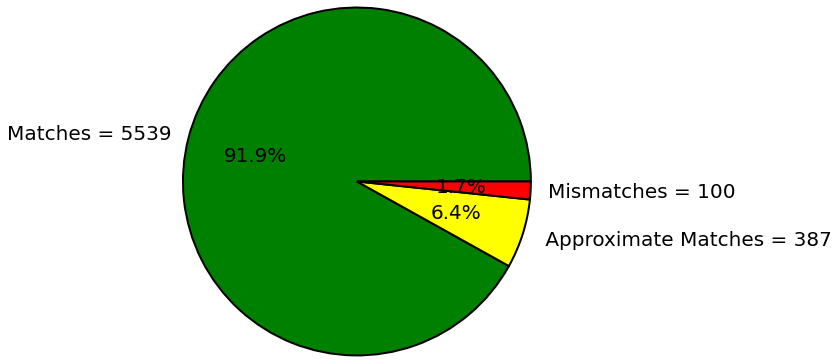

In [37]:
import matplotlib.pyplot as plt

#@title Execute Approximate Matching using Pigeonhole Principle { vertical-output: true, display-mode: "form" }
allowable_mismatches = 2 #@param {type:"slider", min:0, max:10, step:1}

values = approximate_Read_Alignment( allowable_mismatches )
mywedge = { "edgecolor" : "0" , "linewidth" : 2 , "linestyle" : "solid" , "antialiased" : True }
mylabels = [ "Matches = " + str(values[0]) , " Approximate Matches = " + str(values[1]) ,"Mismatches = " + str(values[2]) ]
mytext = {'fontsize': 20}
plt.pie( values , labels = mylabels , colors = [ "green" , "yellow" , "red" ] , autopct="%1.1f%%" , wedgeprops = mywedge , radius = 2 , textprops = mytext )
plt.show()


## Final Read Alignment using Dynamic Programming
We use Pigeonhole Principle to estimate the range where the read may exist and use Dynamic Programming as the verification step.

In [40]:
def dynamic_verification( p , t , allowable_mismatches ) :
    dp = []
    alignments = []
    p = p[::-1]
    t = t[::-1]
    for i in range( len(p)+1 ) :
        dp.append( [0] * (len(t)+1) )
    for i in range( len(p)+1 ) :
        dp[i][0] = i
    for i in range( 1 , len(p)+1 ) :
        for j in range( 1 , len(t)+1 ) :
            hor_dist = dp[i][j-1] + 1
            ver_dist = dp[i-1][j] + 1
            dia_dist = dp[i-1][j-1]
            if p[i-1] != t[j-1] :
                dia_dist += 1
            dp[i][j] = min( hor_dist , ver_dist , dia_dist )
            
    for i in range( len(t)+1 ) :
        if dp[len(p)][i] <= allowable_mismatches :
            alignments.append( len(t) - i )
    return alignments , min( dp[len(p)] )

def pigeonhole_dp( read , bwt , allowable_mismatches ) :
    slices = allowable_mismatches
    segment_length = round(len(read) / (slices+1))
    matches = []
    approximate_match = True
    previous_hits = []
    for i in range( slices+1 ) :
        start = i * segment_length
        end = min( (i+1) * segment_length , len( read ) )
        hits = bwt.match( read[start:end] )
        for h in hits :
            if h < start or h-start+len(read) > bwt.length-1 or (h-start) in previous_hits :
                continue
            previous_hits.append( h-start )
            text_start , text_end = h-start-allowable_mismatches , h-start+len(read)+allowable_mismatches
            if text_start < 0 :
                text_start = 0
            if text_end > bwt.length-1 :
                text_end = bwt.length-1
            alignments , mismatches = dynamic_verification( read , bwt.genome[ text_start : text_end+1 ] , allowable_mismatches )
            if len(alignments) :
                for i in alignments :
                    matches.append( text_start + i )
                if not mismatches :
                    approximate_match = False
    return matches , approximate_match

def dynamic_Read_Alignment( allowable_mismatches ) :
    exact_matches = 0
    approximate_matches = 0
    mismatches = 0
    bwt = Burrows_Wheelers()
    count = 0
    with open( "sample_reads" , "r" ) as f1 , open( "reads_indexes" , "r" ) as f2  :
        for read in f1 :
            offset = int(f2.readline())
            result , approx = pigeonhole_dp( read.strip("\n") , bwt , allowable_mismatches )
            if offset in result :
                if approx == True :
                    approximate_matches += 1
                else :
                    exact_matches += 1
            else :
                mismatches += 1
            count += 1
    return ( exact_matches , approximate_matches , mismatches )

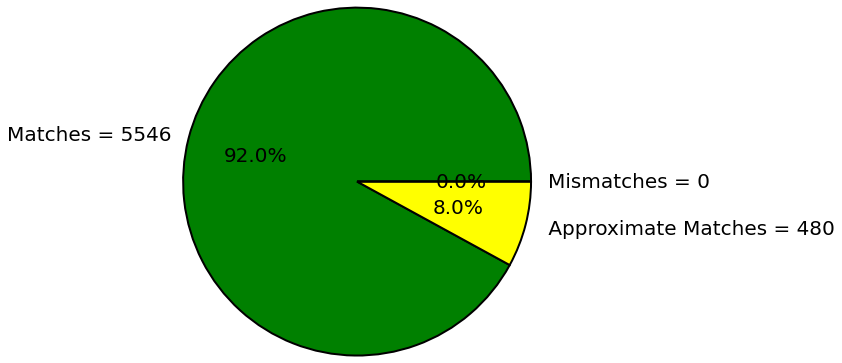

In [42]:
import matplotlib.pyplot as plt

#@title Execute Final read alignment using Pigeon Hole Principle and Dynamic Programming { vertical-output: true, display-mode: "form" }

allowable_mismatches = 3 #@param {type:"slider", min:0, max:10, step:1}

values = dynamic_Read_Alignment( allowable_mismatches )
mywedge = { "edgecolor" : "0" , "linewidth" : 2 , "linestyle" : "solid" , "antialiased" : True }
mylabels = [ "Matches = " + str(values[0]) , " Approximate Matches = " + str(values[1]) ,"Mismatches = " + str(values[2]) ]
mytext = {'fontsize': 20}
plt.pie( values , labels = mylabels , colors = [ "green" , "yellow" , "red" ] , autopct="%1.1f%%" , wedgeprops = mywedge , radius = 2 , textprops = mytext )
plt.show()
